In [1]:
#self_confining.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 15 April 2018.
#plot evolution of self-confining ringlet

In [2]:
#restore output
from helper_fns import *
execfile('inputs.py')
r, t, vr, vt, times, lambda0, monitor = restore_output(output_folder)
a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
print 'r.shape = ', r.shape
print 'total_ring_mass = ', total_ring_mass
print 'shear_viscosity = ', shear_viscosity
print 'bulk_viscosity = ', bulk_viscosity
print 'initial_orbits = ', initial_orbits
print 'fast_gravity = ', fast_gravity
print 'e.min() = ', e.min()
print 'e.max() = ', e.max()
print 'monitor = ', monitor
print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0

r.shape =  (1001, 2, 241)
total_ring_mass =  2e-09
shear_viscosity =  1e-11
bulk_viscosity =  1.5e-11
initial_orbits =  {'w_prime': 0.0, 'shape': 'eccentric', 'e': 0.01, 'e_prime': 0.0}
fast_gravity =  False
e.min() =  0.008308767322662945
e.max() =  0.010927859948316777
monitor =  {'current_time': 1596171788, 'start_time': 1596170923, 'nan_timestep': None, 'streamline_crossing_timestep': None}
execution time (minutes) =  14.4166666667


In [3]:
#time in units of viscous timescale
viscous_timescale = (radial_width**2)/(12*np.abs(shear_viscosity))
print 'viscous_timescale = ', viscous_timescale
times_viscous = times/viscous_timescale

viscous_timescale =  2083.333333333333


In [4]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd

In [5]:
#calculate differences da, de, dwt between outer & inner streamline's periapse
from libration import *
a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = orbit_deltas(times, r, a, e, wt)

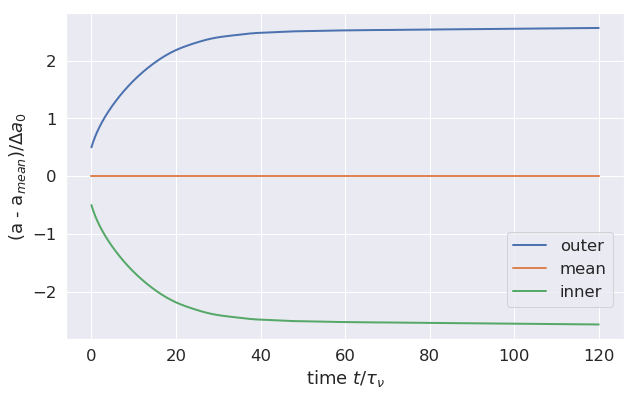

In [6]:
#plot streamline's mutual a-evolution
da_init = da[0]
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
x = times_viscous
y = (a_outer - a_mean)/da_init
p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='outer')
y = (a_mean - a_mean)/da_init
p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='mean')
y = (a_inner - a_mean)/da_init
p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
p = ax.legend(loc=(0.79, 0.1))
plt.savefig('figs/a_nominal.pdf', bbox_inches='tight')

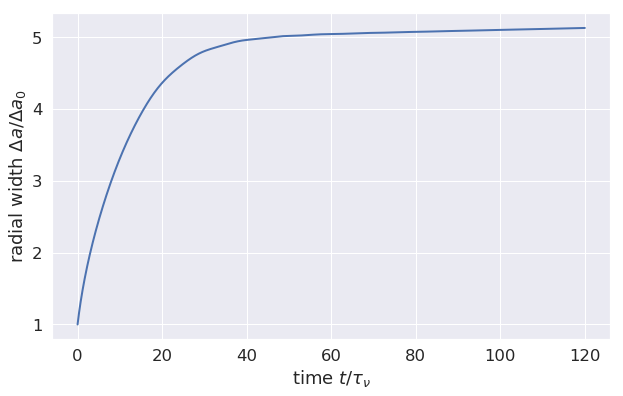

In [7]:
#plot delta_a versus time
x = times_viscous
y = da/da_init
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
p = ax.plot(x, y, linestyle='-', linewidth=2)
p = ax.set_ylabel(r'radial width $\Delta a/\Delta a_0$')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
plt.savefig('figs/da_nominal.pdf', bbox_inches='tight')

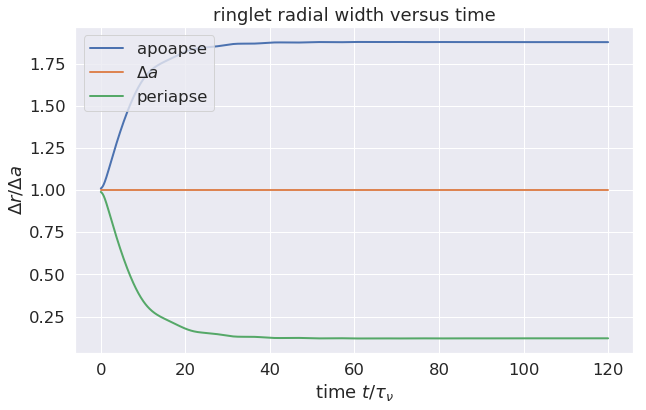

In [8]:
#plot streamline's dr_peri and dr_apo vs time
q_inner = a_inner*(1.0 - e_inner)
q_outer = a_outer*(1.0 - e_outer)
Q_inner = a_inner*(1.0 + e_inner)
Q_outer = a_outer*(1.0 + e_outer)
dr_peri = q_outer - q_inner
dr_apo = Q_outer - Q_inner
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
x = times_viscous
y = dr_apo/da
p = ax.plot(x, y, linestyle='-', linewidth=2, label='apoapse')
y = da/da
p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a$')
y = dr_peri/da
p = ax.plot(x, y, linestyle='-', linewidth=2, label='periapse')
p = ax.set_title('ringlet radial width versus time')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r'$\Delta r/\Delta a$')
p = ax.legend()

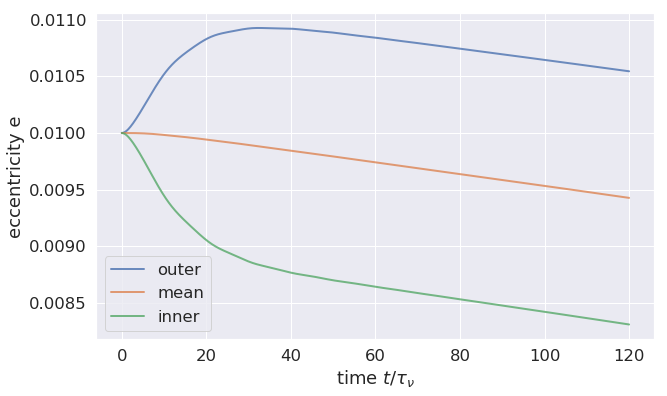

In [9]:
#plot streamline's e-evolution
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
x = times_viscous
y = e_outer
p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
y = e_mean
p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
y = e_inner
p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
p = ax.set_ylabel('eccentricity e')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.legend()
plt.savefig('figs/e_nominal.pdf', bbox_inches='tight')

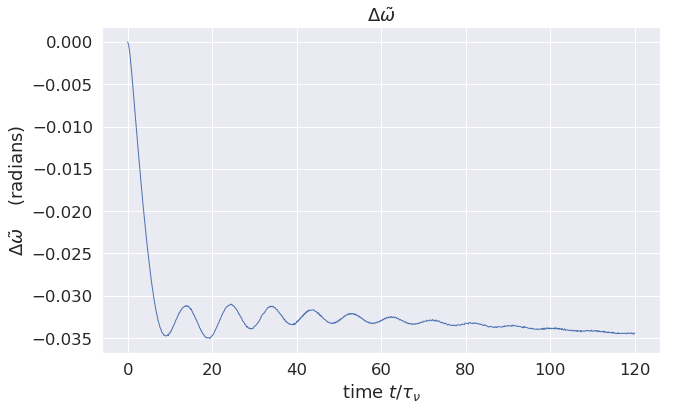

In [10]:
#plot dwt versus time
x = times_viscous
y = dwt
f, ax = plt.subplots(figsize=(10, 6))
p = ax.plot(x, y, linestyle='-', linewidth=1)
p = ax.set_title(r'$\Delta\tilde{\omega}$')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
#p = ax.set_ylim(-0.037, 0.0)

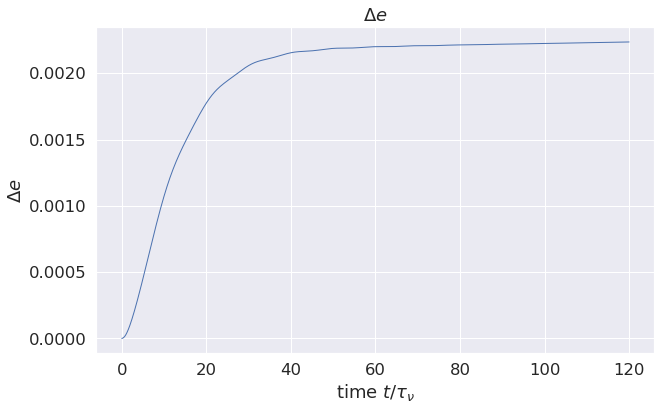

In [11]:
#plot delta_e versus time
x = times_viscous
y = de
f, ax = plt.subplots(figsize=(10, 6))
p = ax.plot(x, y, linestyle='-', linewidth=1)
p = ax.set_title(r'$\Delta e$')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r'$\Delta e$')
#p = ax.set_ylim(-0.0001, 0.003)

In [12]:
#compute e_prime, wt_prime, q to lowest order, and H(q)
H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
H_avg = H.mean()

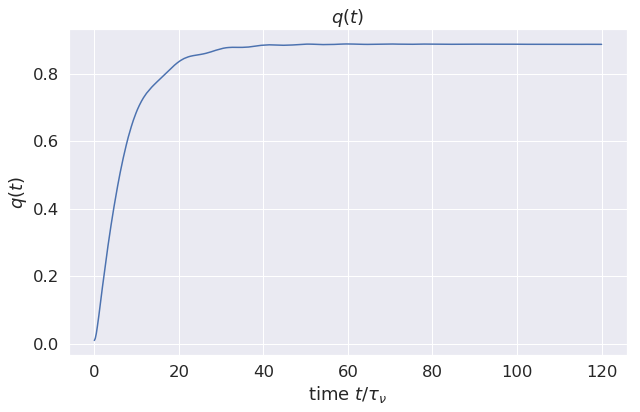

In [13]:
#plot q versus time
x = times_viscous
y = q
f, ax = plt.subplots(figsize=(10, 6))
p = ax.plot(x, y, linestyle='-')
p = ax.set_title(r'$q(t)$')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r'$q(t)$')

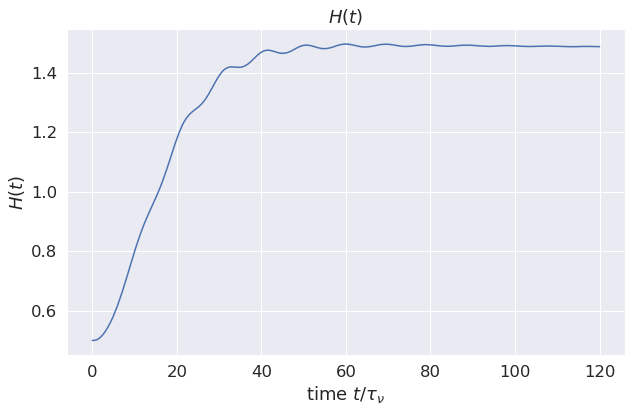

In [14]:
#plot H(q) versus time
x = times_viscous
y = H
f, ax = plt.subplots(figsize=(10, 6))
p = ax.plot(x, y, linestyle='-')
p = ax.set_title(r'$H(t)$')
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r'$H(t)$')

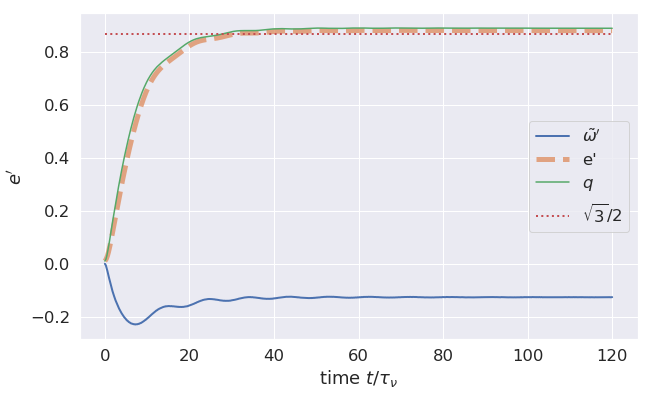

In [15]:
#plot e_prime wt_prime and q versus time
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
x = times_viscous
y = wt_prime
p = ax.plot(x, y, linestyle='-', linewidth=2, label=r"$\tilde{\omega}'$")
y = e_prime
p = ax.plot(x, y, linestyle='dashed', linewidth=5, alpha=0.7, label="e'")
y = q
p = ax.plot(x, y, linestyle='-', linewidth=1.5, label=r'$q$', alpha=1)
p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dotted', linewidth=2, label=r"$\sqrt{3}/2$")
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r"$e'$")
#p = ax.set_ylim(-0.35, 1.05)
p = ax.legend()
plt.savefig('figs/de_prime_nominal.pdf', bbox_inches='tight')

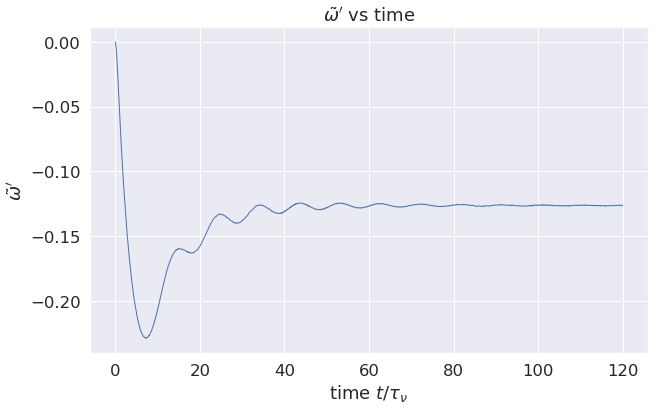

In [16]:
#plot wt_prime versus time
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
x = times_viscous
y = wt_prime
p = ax.plot(x, y, linestyle='-', linewidth=1)
p = ax.set_xlabel(r'time $t/\tau_\nu$')
p = ax.set_ylabel(r"$\tilde{\omega}'$")
p = ax.set_title(r"$\tilde{\omega}'$ vs time")